In [1]:
!pip install shap


In [2]:
!pip install lightgbm


In [1]:
import pandas as pd
import joblib
import shap
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv(r"C:\Users\ADMIN\Desktop\ipl_score\data\processed\dataset.csv")
print(df.columns.tolist())


['batter', 'date', 'venue', 'bowling_team', 'rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg', 'next_match_runs', 'rolling_wkts_5', 'bowler_venue_avg', 'bowler_career_avg', 'bowler_vs_team_avg', 'next_match_wicket']


In [3]:
#Runs
X_runs = df[
    ['rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg']
]

y_runs = df['next_match_runs']



In [4]:
#wickets
X_wickets = df[
    ['rolling_wkts_5', 'bowler_venue_avg', 'pvt_avg', 'pvp_avg',
     'bowler_career_avg', 'bowler_vs_team_avg']
]

y_wickets = df['next_match_wicket']


In [5]:
split = int(len(df) * 0.8)

# Runs
Xr_train, Xr_test = X_runs[:split], X_runs[split:]
yr_train, yr_test = y_runs[:split], y_runs[split:]

# Wickets
Xw_train, Xw_test = X_wickets[:split], X_wickets[split:]
yw_train, yw_test = y_wickets[:split], y_wickets[split:]


In [8]:
# Baseline prediction using rolling runs average
baseline_pred_runs = Xr_test['rolling_avg_5']

baseline_rmse_runs = np.sqrt(mean_squared_error(yr_test, baseline_pred_runs))
baseline_mae_runs  = mean_absolute_error(yr_test, baseline_pred_runs)
baseline_r2_runs   = r2_score(yr_test, baseline_pred_runs)

print("Baseline RMSE (Runs):", baseline_rmse_runs)
print("Baseline MAE (Runs):", baseline_mae_runs)
print("Baseline R² (Runs):", baseline_r2_runs)


Baseline RMSE (Runs): 6.62697413999609
Baseline MAE (Runs): 4.9905741596114455
Baseline R² (Runs): -0.0726599668181882


In [9]:
# Baseline prediction using rolling wickets average
baseline_pred_wkts = Xw_test['rolling_wkts_5']

# Metrics
baseline_rmse_wkts = np.sqrt(mean_squared_error(yw_test, baseline_pred_wkts))
baseline_mae_wkts = mean_absolute_error(yw_test, baseline_pred_wkts)
baseline_r2_wkts = r2_score(yw_test, baseline_pred_wkts)

print("Baseline MAE (Wickets):", baseline_mae_wkts)
print("Baseline RMSE (Wickets):", baseline_rmse_wkts)
print("Baseline R² (Wickets):", baseline_r2_wkts)

Baseline MAE (Wickets): 0.3689959528330718
Baseline RMSE (Wickets): 0.4713486323193486
Baseline R² (Wickets): -0.1990442039351734


In [10]:
#Random Forest-runs
rf_runs = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf_runs.fit(Xr_train, yr_train)
rf_runs_pred = rf_runs.predict(Xr_test)


In [11]:
# XGB - runs
xgb_runs = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_runs.fit(Xr_train, yr_train)
xgb_runs_pred = xgb_runs.predict(Xr_test)


In [12]:
# LGBM - runs
lgb_runs = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)


lgb_runs.fit(Xr_train, yr_train)
lgb_runs_pred = lgb_runs.predict(Xr_test)


[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 5
[LightGBM] [Info] Start training from score 6.038306


In [13]:
#RUNS - model evaluation
def evaluate(yr_true, yr_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yr_true, yr_pred)))
    print("MAE:", mean_absolute_error(yr_true, yr_pred))
    print("R2:", r2_score(yr_true, yr_pred))


evaluate(yr_test, rf_runs_pred, "Random Forest")
evaluate(yr_test, xgb_runs_pred, "XGBoost")
evaluate(yr_test, lgb_runs_pred, "LightGBM")



 Random Forest
RMSE: 5.925638505711751
MAE: 4.459047322484622
R2: 0.1423663191580501

 XGBoost
RMSE: 5.959744701592075
MAE: 4.479251583905834
R2: 0.13246534353039763

 LightGBM
RMSE: 5.977685959091049
MAE: 4.493237334690649
R2: 0.12723421655209344


In [14]:
#LightGBM - wickets
lgbw = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)

lgbw.fit(Xw_train, yw_train)

# align features
Xw_test = Xw_test[Xw_train.columns]

lgbw_pred = lgbw.predict(Xw_test)


[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 6
[LightGBM] [Info] Start training from score 0.237616


In [15]:
#XGBoost - Wickets
xgbw = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgbw.fit(Xw_train, yw_train)
xgbw_pred = xgbw.predict(Xw_test)



In [16]:
# Train the Random Forest model for wickets
rfw = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rfw.fit(Xw_train, yw_train)

# Predict on test data
rfw_pred = rfw.predict(Xw_test)

In [17]:
#WICKETS - model evaluation
def evaluate(yw_true, yw_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yw_true, yw_pred)))
    print("MAE:", mean_absolute_error(yw_true, yw_pred))
    print("R2:", r2_score(yw_true, yw_pred))

evaluate(yw_test, rfw_pred, "Random Forest")
evaluate(yw_test, xgbw_pred, "XGBoost")
evaluate(yw_test, lgbw_pred, "LightGBM")



 Random Forest
RMSE: 0.41368055132810555
MAE: 0.33752029466464484
R2: 0.07640643430061822

 XGBoost
RMSE: 0.4141914466819646
MAE: 0.3365126135226582
R2: 0.07412375007327077

 LightGBM
RMSE: 0.415420538438928
MAE: 0.33611911089013086
R2: 0.06862061699530986


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

grid_rf.fit(Xr_train, yr_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF RMSE:", -grid_rf.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END max_depth=5, min_samples_leaf

In [19]:
print("Best RF Params:", grid_rf.best_params_)
print("Best RF RMSE:", -grid_rf.best_score_)


Best RF Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best RF RMSE: 5.481490437149648


In [20]:

paramw_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gridw_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

gridw_rf.fit(Xw_train, yw_train)

print("Best RF Params:", gridw_rf.best_params_)
print("Best RF RMSE:", -gridw_rf.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   5.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   5.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END max_depth=5, min_samples_leaf

In [21]:
print("Best RF Params:", gridw_rf.best_params_)
print("Best RF RMSE:", -gridw_rf.best_score_)

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best RF RMSE: 0.4146603116958309


In [23]:
rf_runs.fit(Xr_train, yr_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
rfw.fit(Xw_train, yw_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


ExactExplainer explainer: 10574it [4:47:40,  1.64s/it]                                                                 


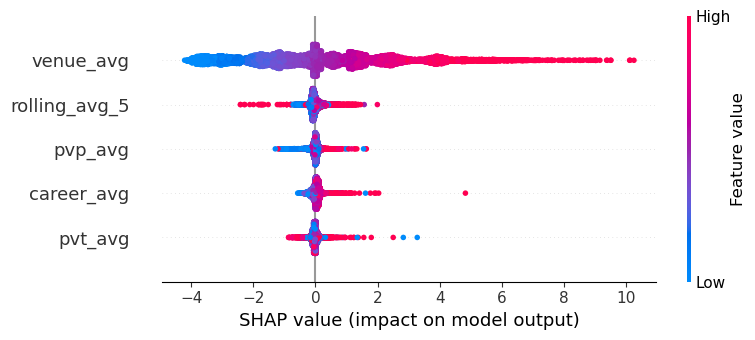

In [29]:
import shap

explainer = shap.Explainer(rf_runs.predict, Xr_train)
shap_values = explainer(Xr_test)

shap.summary_plot(shap_values, Xr_test)


ExactExplainer explainer: 10574it [36:31,  4.80it/s]                                                                   


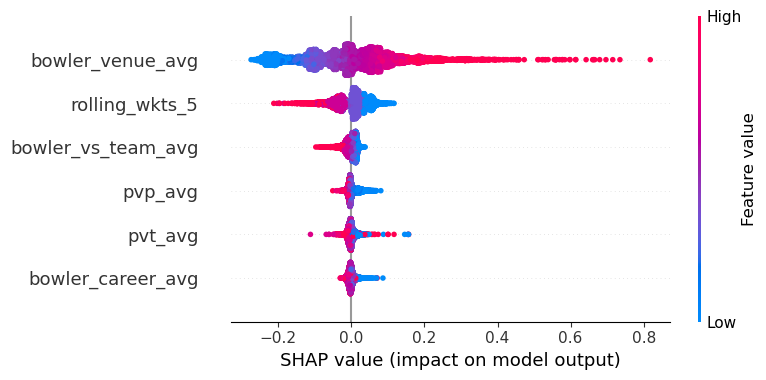

In [30]:
explainer = shap.Explainer(rfw.predict, Xw_train)
shap_values = explainer(Xw_test)

shap.summary_plot(shap_values, Xw_test)

In [32]:
joblib.dump(rf_runs, r"C:\Users\ADMIN\Desktop\ipl_score\scripts\rf_model.joblib")
print("rf_model.joblib saved for runs!")


rf_model.joblib saved for runs!


In [33]:
joblib.dump(rfw, r"C:\Users\ADMIN\Desktop\ipl_score\scripts\rfw_model.joblib")
print("rfw_model.joblib saved for wickets!")

rfw_model.joblib saved for wickets!
